# Mel Spectrogram CNN for RAVDESS

RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song) contains 1,440 spoken audio clips labeled with eight emotions. A **mel spectrogram** plots time (x-axis) against frequency (y-axis) while coloring each pixel by signal intensity; applying the mel scale makes the frequency axis better match how humans perceive pitch. Because mel spectrograms are image-like, **convolutional neural networks (CNNs)** can learn patterns that span time and frequency to detect emotions.

In this notebook we will turn each RAVDESS clip into a mel spectrogram and train a small CNN to predict the emotion. The dataset is still small (~1.4k clips), so we treat this as an educational baseline and expect modest accuracy with potential overfitting.

## Imports and basic configuration

In [1]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

AUDIO_ROOT = Path("../data/ravdess_data")
MELSPEC_ROOT = Path("../data/processed/melspec")
MODEL_PATH = Path('../models/ravdess_melspec_cnn_best.pt')

SAMPLE_RATE = 22050
N_MELS = 64
HOP_LENGTH = 512
FMIN = 0
FMAX = SAMPLE_RATE // 2
MAX_FRAMES = 200  # fixed time dimension for spectrograms


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Discover audio files and labels

RAVDESS filenames follow a pattern such as `03-01-05-01-02-01-12.wav`. The **third** field encodes the emotion:

* 01 neutral
* 02 calm
* 03 happy
* 04 sad
* 05 angry
* 06 fearful
* 07 disgust
* 08 surprised

We'll parse each filename and build a simple metadata table with the file path and human-readable emotion label.

In [2]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}


def parse_emotion_from_filename(path: Path) -> str:
    parts = path.stem.split('-')
    if len(parts) < 3:
        raise ValueError(f"Unexpected filename format: {path.name}")
    code = parts[2]
    if code not in emotion_map:
        raise ValueError(f"Unknown emotion code {code} in {path.name}")
    return emotion_map[code]


file_paths = sorted(AUDIO_ROOT.rglob("*.wav"))
print(f"Discovered {len(file_paths)} .wav files under {AUDIO_ROOT}")

records = []
for path in file_paths:
    records.append({
        "file_path": str(path),
        "emotion": parse_emotion_from_filename(path),
    })

meta_df = pd.DataFrame(records)
meta_df.head()


Discovered 1440 .wav files under ../data/ravdess_data


,file_path,emotion
0,../data/ravdess_data/Actor_01/03-01-01-01-01-0...,neutral
1,../data/ravdess_data/Actor_01/03-01-01-01-01-0...,neutral
2,../data/ravdess_data/Actor_01/03-01-01-01-02-0...,neutral
3,../data/ravdess_data/Actor_01/03-01-01-01-02-0...,neutral
4,../data/ravdess_data/Actor_01/03-01-02-01-01-0...,calm


In [3]:
meta_df['emotion'].value_counts()

emotion
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

Class counts are roughly balanced (each actor speaks every emotion twice), so every class has about the same number of clips.

## Train / validation / test split

We carve the metadata into separate sets:

* **Train**: model learns the weights.
* **Validation**: monitor progress after each epoch to tune hyperparameters and detect overfitting.
* **Test**: only used once at the end for an unbiased estimate.

Because the dataset is small, we use **stratified** splits so each subset keeps a similar emotion distribution.

In [4]:
train_df, temp_df = train_test_split(
    meta_df,
    test_size=0.3,
    stratify=meta_df['emotion'],
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['emotion'],
    random_state=42
)

for name, split in [('Train', train_df), ('Validation', val_df), ('Test', test_df)]:
    print(f"{name}: {len(split)} samples")
    print(split['emotion'].value_counts(), "")


Train: 1008 samples
emotion
angry        135
sad          135
calm         135
fearful      134
surprised    134
disgust      134
happy        134
neutral       67
Name: count, dtype: int64 
Validation: 216 samples
emotion
disgust      29
fearful      29
happy        29
angry        29
surprised    29
sad          28
calm         28
neutral      15
Name: count, dtype: int64 
Test: 216 samples
emotion
surprised    29
fearful      29
sad          29
happy        29
disgust      29
calm         29
angry        28
neutral      14
Name: count, dtype: int64 


Each split maintains similar counts per emotion, which keeps the evaluation fair.

## Mel spectrogram helpers and quick visualization

A mel spectrogram converts the waveform into a 2D matrix (mel bands × time). Key knobs:

* `N_MELS`: number of mel frequency bins (here 64).
* `HOP_LENGTH`: samples between adjacent frames (controls time resolution).
* `FMIN`/`FMAX`: min and max frequencies kept.

We cache each mel spectrogram to disk so repeated runs avoid recomputation.

In [5]:
def compute_melspec(path: Path) -> np.ndarray:
    y, sr = librosa.load(path, sr=SAMPLE_RATE)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=N_MELS,
        hop_length=HOP_LENGTH,
        fmin=FMIN,
        fmax=FMAX
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    return S_db.astype(np.float32)


def melspec_cache_path(wav_path: Path) -> Path:
    relative = wav_path.relative_to(AUDIO_ROOT)
    cache_path = MELSPEC_ROOT / relative
    return cache_path.with_suffix('.npy')


def get_or_create_melspec(wav_path: Path) -> np.ndarray:
    cache_path = melspec_cache_path(wav_path)
    if cache_path.exists():
        return np.load(cache_path)
    S_db = compute_melspec(wav_path)
    cache_path.parent.mkdir(parents=True, exist_ok=True)
    np.save(cache_path, S_db)
    return S_db

def pad_or_trim(spec: np.ndarray, max_frames: int = MAX_FRAMES) -> np.ndarray:
    if spec.shape[1] < max_frames:
        pad_width = max_frames - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode="constant")
    elif spec.shape[1] > max_frames:
        spec = spec[:, :max_frames]
    return spec


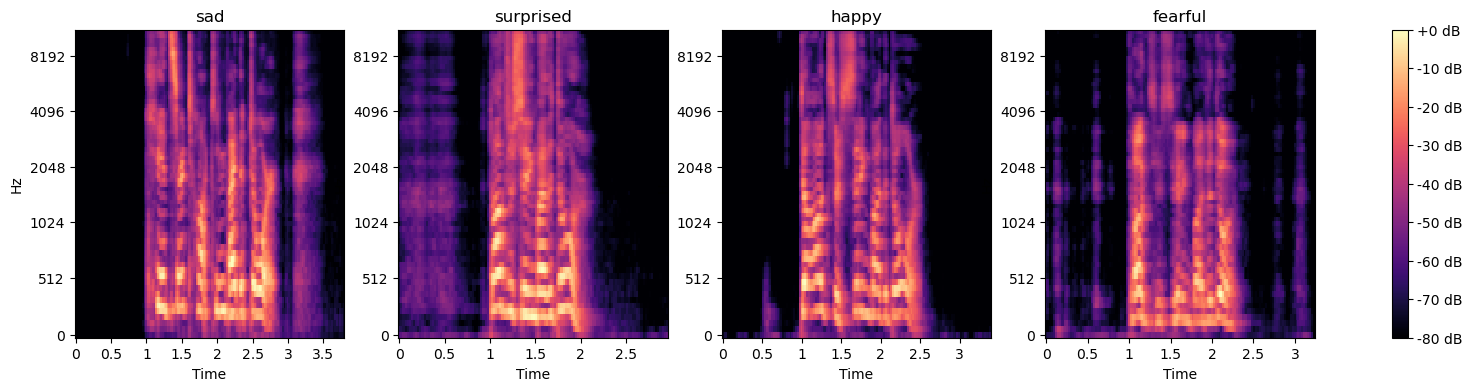

In [6]:
sampled = train_df.sample(n=min(4, len(train_df)), random_state=42)
fig, axes = plt.subplots(1, len(sampled), figsize=(20, 4))
if len(sampled) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, sampled.iterrows()):
    wav_path = Path(row['file_path'])
    S_db = get_or_create_melspec(wav_path)
    img = librosa.display.specshow(
        S_db,
        sr=SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='mel',
        fmax=FMAX,
        ax=ax
    )
    ax.set_title(row['emotion'])

fig.colorbar(img, ax=axes, format="%+2.f dB")
# plt.tight_layout()
plt.show()


def pad_or_trim(spec: np.ndarray, max_frames: int = MAX_FRAMES) -> np.ndarray:
    if spec.shape[1] < max_frames:
        pad_width = max_frames - spec.shape[1]
        spec = np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')
    elif spec.shape[1] > max_frames:
        spec = spec[:, :max_frames]
    return spec


Brighter stripes indicate stronger energy at specific frequencies. Different emotions show distinct energy patterns and timing, which the CNN will attempt to learn.

## Label encoding and PyTorch datasets

PyTorch needs numeric labels, so we map each emotion to an integer. A `Dataset` loads individual samples, and a `DataLoader` batches them with shuffling.

In [7]:
EMOTION_TO_IDX = {label: idx for idx, label in enumerate(sorted(meta_df['emotion'].unique()))}
IDX_TO_EMOTION = {idx: label for label, idx in EMOTION_TO_IDX.items()}
print('Label mapping:', EMOTION_TO_IDX)

Label mapping: {'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [8]:
class RavdessMelSpecDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.df = df.reset_index(drop=True)

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        wav_path = Path(row['file_path'])
        emotion = row['emotion']
        S_db = get_or_create_melspec(wav_path)
        S_db = pad_or_trim(S_db, MAX_FRAMES)
        mean = S_db.mean()
        std = S_db.std() + 1e-6
        S_norm = (S_db - mean) / std
        tensor = torch.from_numpy(S_norm).unsqueeze(0).float()
        label = torch.tensor(EMOTION_TO_IDX[emotion]).long()
        return tensor, label


In [9]:
BATCH_SIZE = 32

train_dataset = RavdessMelSpecDataset(train_df)
val_dataset = RavdessMelSpecDataset(val_df)
test_dataset = RavdessMelSpecDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_batch, y_batch = next(iter(train_loader))
print('Batch spectrogram shape:', X_batch.shape)
print('Batch labels shape:', y_batch.shape)


Batch spectrogram shape: torch.Size([32, 1, 64, 200])
Batch labels shape: torch.Size([32])


`(batch, channels, mel_bands, time_steps)` shows we have 32 spectrogram "images" per batch, with one channel and 64 mel rows.

## Simple CNN architecture

A convolutional neural network stacks layers that:

1. Apply convolutions to capture local time-frequency patterns.
2. Apply ReLU nonlinearities for expressive power.
3. Use pooling or downsampling to condense information.

After feature extraction, a fully-connected head predicts our eight emotions. This network stays shallow for clarity.

In [10]:
class RAVDESSMapDataset(Dataset):
    def __init__(self, df: pd.DataFrame, emotion_to_idx: dict) -> None:
        self.df = df
        self.emotion_to_idx = emotion_to_idx

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        wav_path = Path(row['file_path'])
        label_str = row['emotion']

        # Load and process mel spec
        mel_spec = get_or_create_melspec(wav_path)
        mel_spec = pad_or_trim(mel_spec, MAX_FRAMES)
        
        # Add channel dimension: (1, n_mels, time)
        mel_spec_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0)
        
        label_idx = self.emotion_to_idx[label_str]
        label_tensor = torch.tensor(label_idx, dtype=torch.long)
        
        return mel_spec_tensor, label_tensor


In [11]:
# Create mappings
emotions = sorted(meta_df['emotion'].unique())
idx_to_emotion = {i: e for i, e in enumerate(emotions)}
emotion_to_idx = {e: i for i, e in idx_to_emotion.items()}
IDX_TO_EMOTION = idx_to_emotion # Alias for compatibility

print(f"Classes: {idx_to_emotion}")

# Create Datasets
train_dataset = RAVDESSMapDataset(train_df, emotion_to_idx)
val_dataset = RAVDESSMapDataset(val_df, emotion_to_idx)
test_dataset = RAVDESSMapDataset(test_df, emotion_to_idx)

# Create DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Created loaders: Train={len(train_loader)} batches, Val={len(val_loader)} batches")


Classes: {0: 'angry', 1: 'calm', 2: 'disgust', 3: 'fearful', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprised'}
Created loaders: Train=32 batches, Val=7 batches


In [21]:
class ImprovedMelCNN(nn.Module):
    def __init__(self, n_mels: int, n_classes: int) -> None:
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # Block 4 (New)
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.AdaptiveAvgPool2d((4, 4)),
        )
        
        # Compute flattened size dynamically
        dummy = torch.zeros(1, 1, n_mels, 200)
        with torch.no_grad():
            feat = self.features(dummy)
        flattened = feat.view(1, -1).shape[1]
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flattened, 256),  # Increased size
            nn.ReLU(),
            nn.Dropout(0.4),            # Increased dropout
            nn.Linear(256, n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


# Instantiate the improved model
num_classes = len(idx_to_emotion)
model = ImprovedMelCNN(n_mels=N_MELS, n_classes=num_classes)
# move to device
model.to(device)
print(model)



ImprovedMelCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

* `features` extracts visual patterns from the spectrogram.
* `classifier` maps those patterns to eight emotion logits.
* ReLU brings non-linearity, Dropout regularizes the dense layers.

## Training loop overview

During each epoch:

1. Training batches run forward → loss → backward → optimizer updates.
2. Validation batches run forward only to monitor progress.
3. Metrics (loss + accuracy) tell us whether learning is stable.
4. We save the model when validation accuracy reaches a new best.

This mirrors standard supervised learning workflows.

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
NUM_EPOCHS = 50
best_val_acc = 0.0
best_path = MODEL_PATH
best_path.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        preds = outputs.argmax(dim=1)
        train_correct += (preds == y_batch).sum().item()
        train_total += X_batch.size(0)

    train_loss /= train_total
    train_acc = train_correct / train_total

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += X_batch.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

    print(f"Epoch {epoch:02d}/{NUM_EPOCHS} - Train loss: {train_loss:.4f}, acc: {train_acc:.3f} | Val loss: {val_loss:.4f}, acc: {val_acc:.3f}")

print(f"Best validation accuracy: {best_val_acc:.3f}")


Epoch 01/50 - Train loss: 2.0773, acc: 0.205 | Val loss: 1.9285, acc: 0.287
Epoch 02/50 - Train loss: 1.9032, acc: 0.234 | Val loss: 1.8552, acc: 0.282
Epoch 03/50 - Train loss: 1.7814, acc: 0.281 | Val loss: 1.7547, acc: 0.319
Epoch 04/50 - Train loss: 1.6556, acc: 0.362 | Val loss: 1.7633, acc: 0.338
Epoch 05/50 - Train loss: 1.6341, acc: 0.376 | Val loss: 1.7059, acc: 0.356
Epoch 06/50 - Train loss: 1.5326, acc: 0.423 | Val loss: 1.5841, acc: 0.431
Epoch 07/50 - Train loss: 1.4303, acc: 0.472 | Val loss: 1.9493, acc: 0.259
Epoch 08/50 - Train loss: 1.3839, acc: 0.492 | Val loss: 1.5007, acc: 0.440
Epoch 09/50 - Train loss: 1.3073, acc: 0.505 | Val loss: 1.7736, acc: 0.329
Epoch 10/50 - Train loss: 1.2600, acc: 0.507 | Val loss: 1.4870, acc: 0.421
Epoch 11/50 - Train loss: 1.2083, acc: 0.540 | Val loss: 1.3811, acc: 0.435
Epoch 12/50 - Train loss: 1.1809, acc: 0.542 | Val loss: 1.3883, acc: 0.486
Epoch 13/50 - Train loss: 1.1735, acc: 0.550 | Val loss: 1.6850, acc: 0.417
Epoch 14/50 

## Test evaluation and diagnostics

We load the best checkpoint and evaluate on the test split to approximate real-world performance. With ~1.4k examples and eight classes, expect moderate accuracy and some confusion between similar emotions.

In [14]:
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

all_preds = []
all_true = []
all_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        probs = torch.softmax(outputs, dim=1)
        preds = probs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y_batch.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())


/tmp/ipykernel_88183/823685823.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=device))


              precision    recall  f1-score   support

       angry       0.82      0.82      0.82        28
        calm       0.74      0.79      0.77        29
     disgust       0.73      0.55      0.63        29
     fearful       0.70      0.79      0.74        29
       happy       0.75      0.41      0.53        29
     neutral       0.67      0.57      0.62        14
         sad       0.40      0.59      0.48        29
   surprised       0.78      0.86      0.82        29

    accuracy                           0.68       216
   macro avg       0.70      0.67      0.68       216
weighted avg       0.70      0.68      0.68       216

Saved confusion matrix to ../output/CNN_plots/ravdess_melspec_confusion_matrix.png


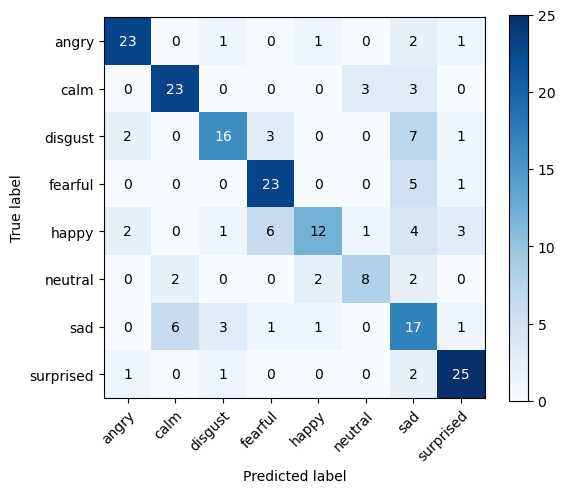

In [15]:
target_names = [IDX_TO_EMOTION[i] for i in range(num_classes)]
print(classification_report(all_true, all_preds, target_names=target_names))

cm = confusion_matrix(all_true, all_preds)
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=range(num_classes),
    yticks=range(num_classes),
    xticklabels=target_names,
    yticklabels=target_names,
    ylabel='True label',
    xlabel='Predicted label'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

for i in range(num_classes):
    for j in range(num_classes):
        ax.text(
            j,
            i,
            cm[i, j],
            ha='center',
            va='center',
            color='white' if cm[i, j] > cm.max() / 2 else 'black'
        )

plt.tight_layout()
output_path = Path('../output/CNN_plots/ravdess_melspec_confusion_matrix.png')
output_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f'Saved confusion matrix to {output_path}')
plt.show()


Diagonal cells show correct predictions; off-diagonal counts are disagreements. Look for patterns like angry vs. fearful confusion, which is common in emotion recognition.

Saved ROC curve to ../output/CNN_plots/ravdess_melspec_roc_curve.png


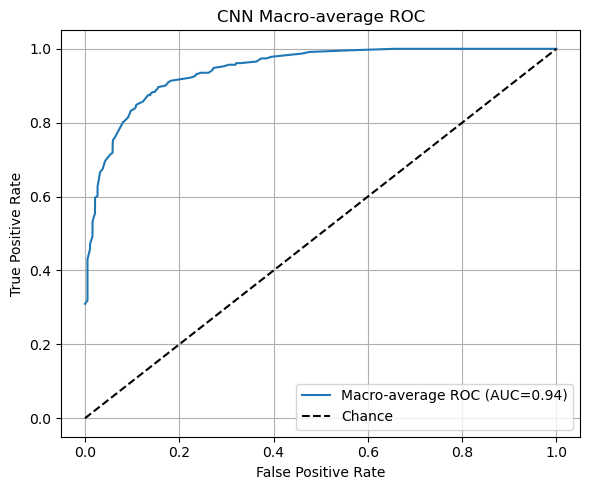

In [16]:
y_true_bin = label_binarize(all_true, classes=list(range(num_classes)))
probs = np.array(all_probs)
all_fpr = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], probs[:, i])[0] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= num_classes
roc_auc = auc(all_fpr, mean_tpr)
plt.figure(figsize=(6, 5))
plt.plot(all_fpr, mean_tpr, label=f'Macro-average ROC (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN Macro-average ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
roc_path = Path('../output/CNN_plots/ravdess_melspec_roc_curve.png')
roc_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(roc_path, dpi=300, bbox_inches='tight')
print(f'Saved ROC curve to {roc_path}')
plt.show()


In [17]:
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)
best_model_path = MODELS_DIR / 'ravdess_melspec_cnn_best.pt'
torch.save(model.state_dict(), best_model_path)
print('Saved best CNN weights to:', best_model_path)


Saved best CNN weights to: ../models/ravdess_melspec_cnn_best.pt


In [18]:
import json

label_mapping_path = MODELS_DIR / 'emotion_label_mapping.json'
with label_mapping_path.open('w') as f:
    json.dump({
        'EMOTION_TO_IDX': EMOTION_TO_IDX,
        'IDX_TO_EMOTION': {int(k): v for k, v in IDX_TO_EMOTION.items()}
    }, f, indent=2)
print('Saved label mappings to:', label_mapping_path)


Saved label mappings to: ../models/emotion_label_mapping.json


In [19]:
config_path = MODELS_DIR / 'ravdess_melspec_config.json'
config = {
    'SAMPLE_RATE': SAMPLE_RATE,
    'N_MELS': N_MELS,
    'HOP_LENGTH': HOP_LENGTH,
    'FMIN': FMIN,
    'FMAX': FMAX
}
with config_path.open('w') as f:
    json.dump(config, f, indent=2)
print('Saved mel-spectrogram config to:', config_path)


Saved mel-spectrogram config to: ../models/ravdess_melspec_config.json


### Saved CNN Assets

* **CNN weights (PyTorch state_dict):** `../models/ravdess_melspec_cnn_best.pt`
* **Emotion label mappings (JSON):** `../models/emotion_label_mapping.json`
* **Mel-spectrogram config (JSON):** `../models/ravdess_melspec_config.json`

These files support later inference by keeping the architecture, label decoding, and preprocessing settings in sync.


## Closing thoughts and link to PyCaret work

We trained a compact CNN on mel spectrograms and tracked its validation / test accuracy. Together with the PyCaret MFCC baselines we now have:

* **PyCaret + MFCCs**: tabular features explored automatically by classical models.
* **CNN + mel spectrograms**: image-like inputs optimized via gradient descent.

Compare their accuracies to gauge the benefit of representation learning. Future upgrades could add data augmentation (time masking, pitch shifts), a deeper CNN, or transfer learning from pretrained audio backbones.